# Trends Analysis of California Independent System Operator (CAISO) Energy Data
#### Kristina Koh
#### 08/15/2023

Goals and approach: Using an API to get historical energy consumption data from CAISO, I will remove outliers and interpolate the missing indices to obtain a more digestible format for analysis. Second, I will define “High Demand Days” and attempt to identify them in a couple methods. Lastly, I will apply Fast Fourier Transform (FFT) to identify seasonal energy usage trends and inverse FFT to reconstruct these trends.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import squarify  
import scipy
import seaborn as sns
import plotly.express as px
import gif
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from itertools import count
from datetime import datetime
from scipy import interpolate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import random
from datetime import timedelta

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('caiso_data.csv')  

In [3]:
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.set_index('datetime', inplace=True)
df.drop(columns=['date', 'time'], inplace=True)

# 1) Exploratory Analysis and Plotting 
Getting a better sense of CAISO raw data

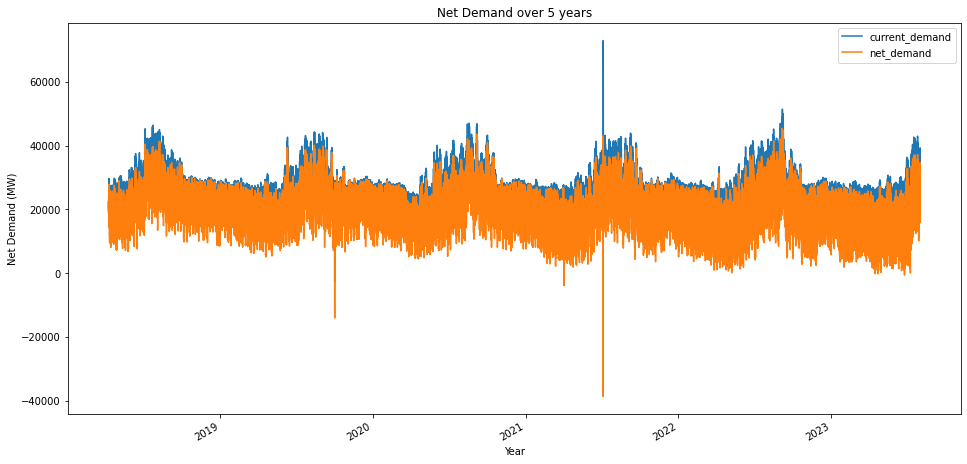

In [4]:
#plot of net demand (demand after solar and wind)
df['current_demand'].plot(figsize=(16,8))
df['net_demand'].plot()
plt.title('Net Demand over 5 years')
plt.ylabel('Net Demand (MW)')
plt.xlabel('Year')
plt.legend(loc="best")
plt.show()

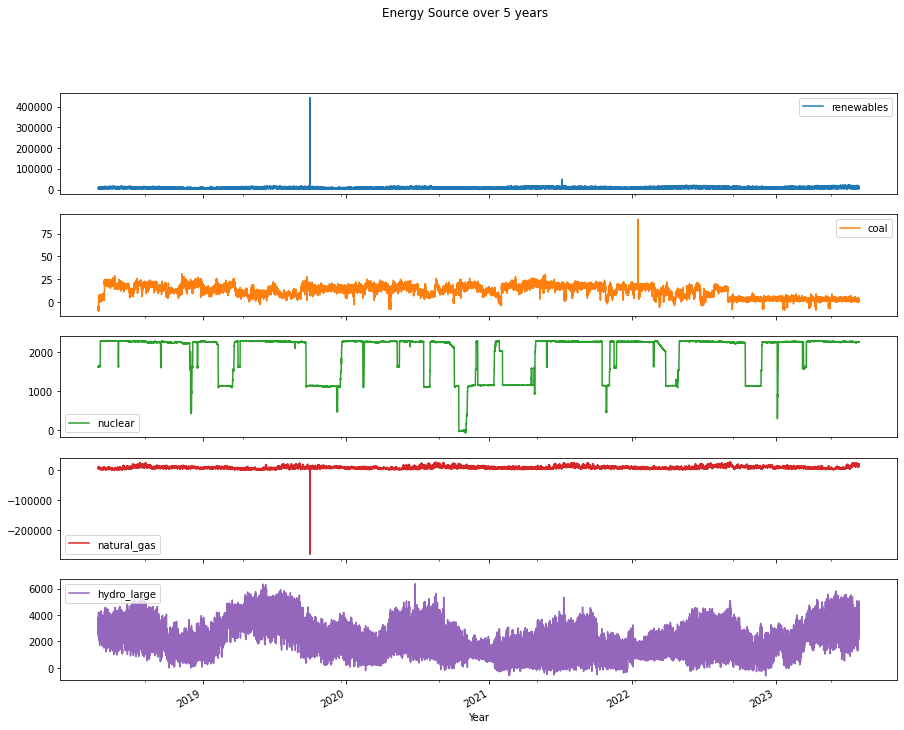

In [5]:
#plot of grid resources
sources = ['renewables','coal','nuclear','natural_gas','hydro_large']
df[sources].plot(subplots=True,figsize=(15,12))
plt.suptitle('Energy Source over 5 years')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

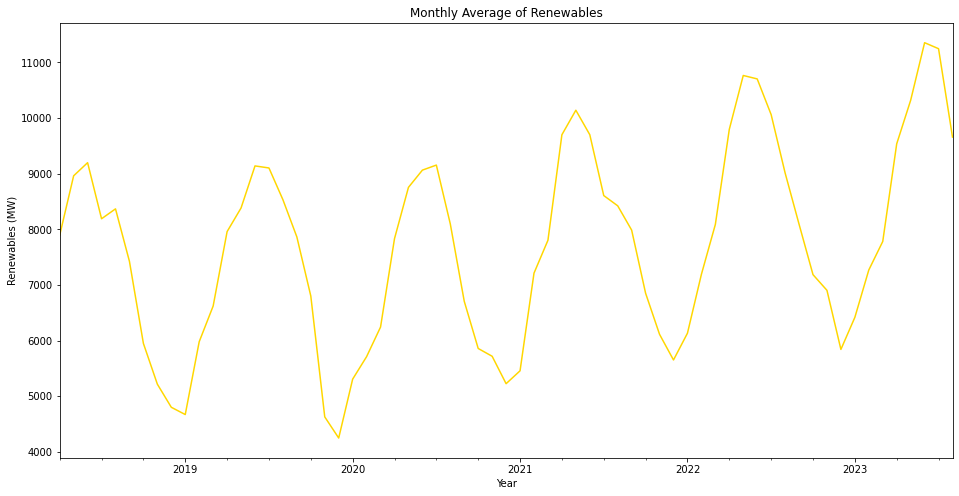

In [6]:
#investigating seasonal patterns of the renewables
df['renewables'].resample('M').mean().plot(figsize=(16,8),color="gold")
plt.title('Monthly Average of Renewables')
plt.ylabel('Renewables (MW)')
plt.xlabel('Year')
plt.show()

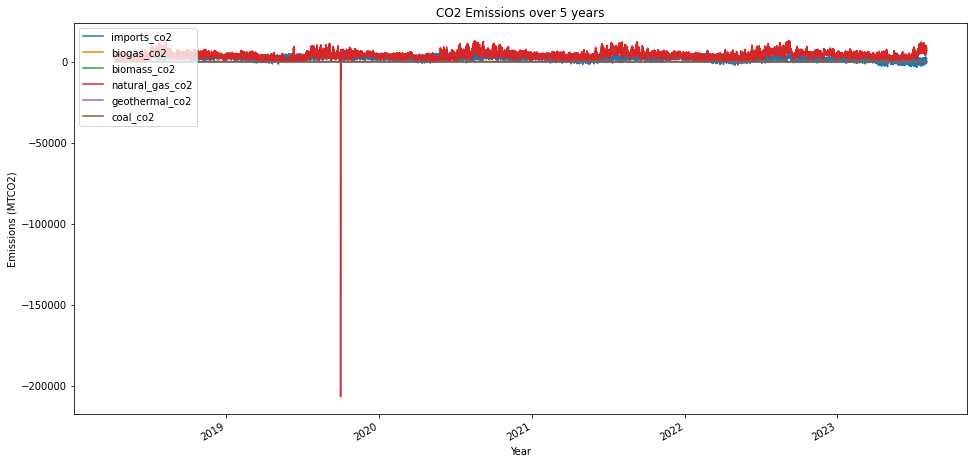

In [7]:
#plotting those with emissions
emissions_columns = ['imports_co2','biogas_co2','biomass_co2','natural_gas_co2','geothermal_co2','coal_co2']
df[emissions_columns].plot(figsize =(16,8))
plt.title('CO2 Emissions over 5 years')
plt.ylabel('Emissions (MTCO2)')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

# 2) Removal of Outliers and using Scipy Interpolation
Visually there are some outliers that can be a result of improper readings. Note: these are 5-minute intervals.

In [11]:
imports_co2_min = df['imports_co2'].min()
coal_max = df['coal'].max()
coal_co2_max = df['coal_co2'].max()
renewables_two_maxs = df['renewables'].nlargest(2).tolist()
biogas_co2_max = df['biogas_co2'].max()
biomass_co2_min = df['biomass_co2'].min()
current_demand_max = df['current_demand'].max()
current_demand_min = df['current_demand'].min()

In [12]:
outlier_indices = df.index[
    (df['imports_co2'] <= imports_co2_min) |
    (df['natural_gas'] < 0) |
    (df['natural_gas_co2'] < 0) |
    (df['coal'] >= coal_max) |
    (df['coal_co2']>= coal_co2_max)|
    (df['renewables'].isin(renewables_two_maxs)) |
    (df['biogas_co2']>= biogas_co2_max) |
    (df['biomass_co2']<= biomass_co2_min) |
    (df['current_demand'] >= current_demand_max) |
    (df['current_demand'] <= current_demand_min) |
    (df['net_demand'] < 0)
].tolist()

In [14]:
df_clean = df.drop(outlier_indices)

In [16]:
#This function is used to compute interpolated values for the data points that were removed
for idx in outlier_indices:
    for column in ['natural_gas', 'natural_gas_co2', 'coal', 'coal_co2', 'renewables', 'biogas_co2','biomass_co2','current_demand', 'net_demand']:
        
        # taking the values from the index
        df_column_clean = df_clean[column].dropna()  # removing nans
        x = df_column_clean.index.values.astype(float)  # convert datetime index to float
        y = df_column_clean.values

        # to interpolate cubic - smoother and higher accuracy. potential issue: cubic may overfit
        f = interpolate.interp1d(x, y, kind='cubic', fill_value=None)
        
        # computer the interpolated value using float version of idx
        interpolated_value = f(float(pd.Timestamp(idx).value))
        df_clean.at[idx, column] = interpolated_value

df_final = df_clean.sort_index()

In [17]:
# debugging x and y in the loop above by finding dimensions
print(np.asarray(df_clean.index.values.astype(float)).shape) #x
print(np.asarray(df_clean.values).shape) #y
#y is not 1D
test = np.asarray(df_clean.values).squeeze()
test[:,0].shape
#test.shape

(556863,)
(556863, 17)


(556863,)

# 3) Replotting post-interpolation

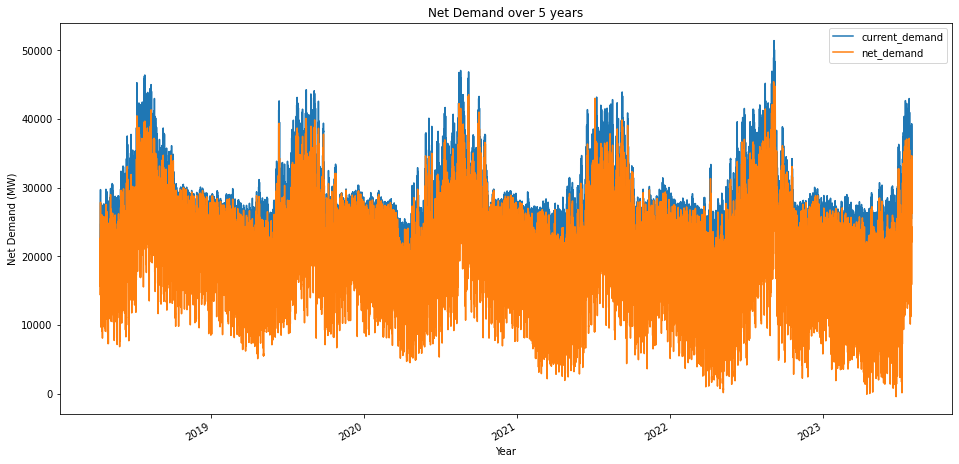

In [18]:
#plot of net demand (demand after solar and wind)
df_final['current_demand'].plot(figsize=(16,8))
df_final['net_demand'].plot()
plt.title('Net Demand over 5 years')
plt.ylabel('Net Demand (MW)')
plt.xlabel('Year')
plt.legend(loc="best")
plt.show()

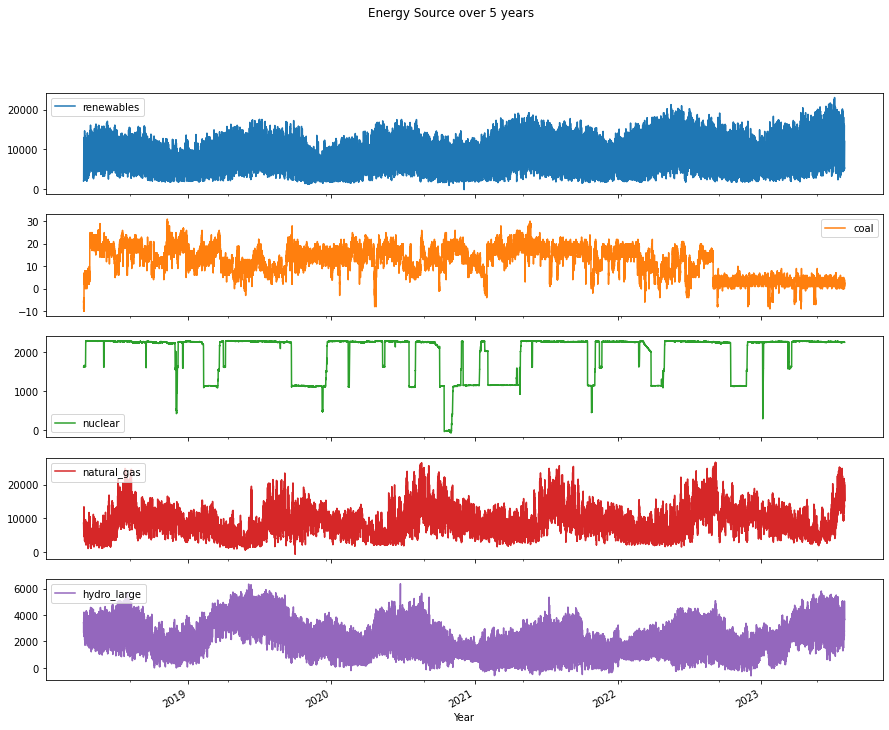

In [19]:
#plot of grid resources
sources = ['renewables','coal','nuclear','natural_gas','hydro_large']
df_final[sources].plot(subplots=True,figsize=(15,12))
plt.suptitle('Energy Source over 5 years')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

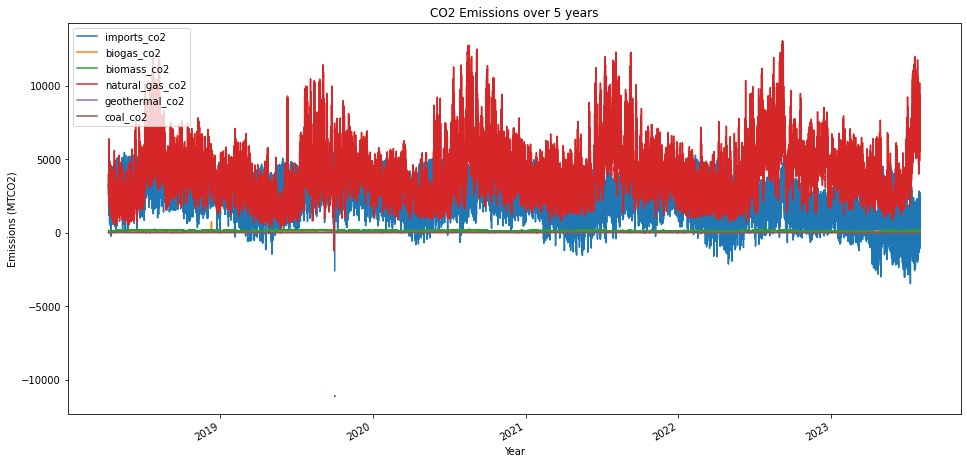

In [20]:
#plotting columns with emissions
emissions_columns = ['imports_co2','biogas_co2','biomass_co2','natural_gas_co2','geothermal_co2','coal_co2']
df_clean[emissions_columns].plot(figsize =(16,8))
plt.title('CO2 Emissions over 5 years')
plt.ylabel('Emissions (MTCO2)')
plt.xlabel('Year')
plt.legend(loc='upper left')
plt.show()

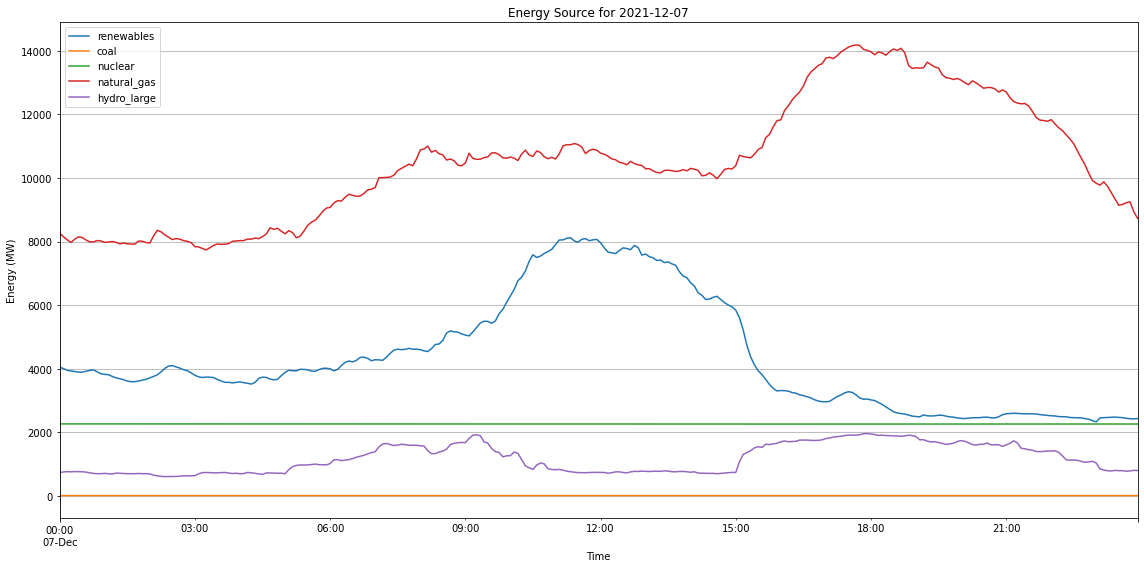

In [136]:
#pick a random day
dates = df_final.index.normalize().unique()  # Extract unique dates from the index
random_date = random.choice(dates)
df_day = df_final[df_final.index.normalize() == random_date]

#plot a random day
df_day[sources].plot(figsize=(16,8), title=f'Energy Source for {random_date.date()}')
plt.xlabel('Time')
plt.ylabel('Energy (MW)')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
 

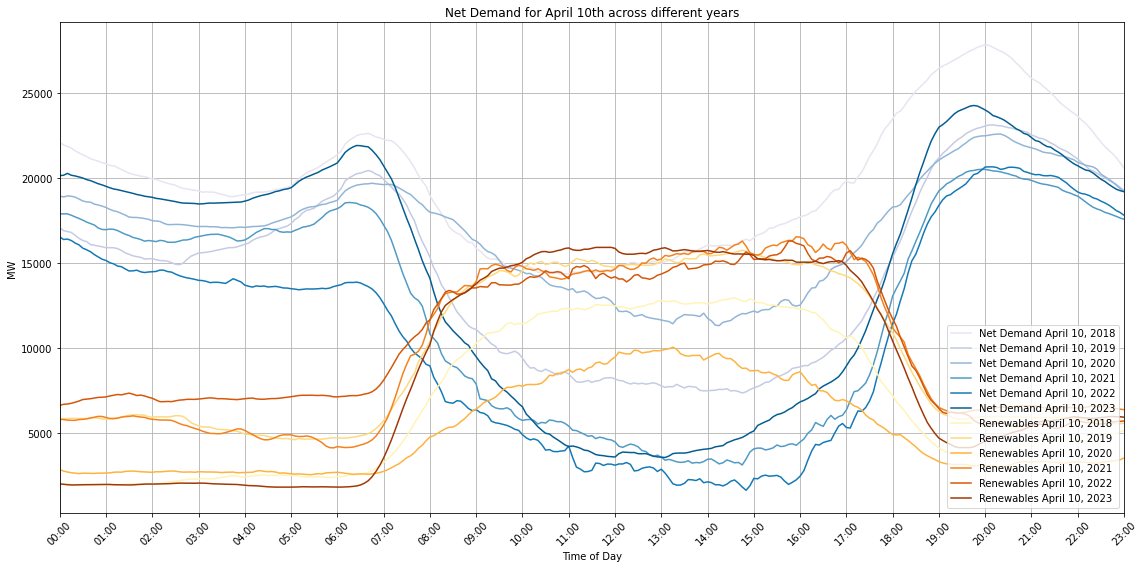

In [27]:
years=[2018,2019,2020,2021,2022,2023]

orange_palette = sns.color_palette("YlOrBr", len(years))
blue_palette = sns.color_palette("PuBu",len(years))
plt.figure(figsize=(16, 8))

all_hours = [f"{hour:02d}:00" for hour in range(24)]

for year, color in zip(years, blue_palette):
    df_day = df_final[df_final.index.date == pd.Timestamp(f"{year}-04-10").date()]
    time_strings = [t.strftime('%H:%M') for t in df_day.index.time]
    plt.plot(time_strings, df_day['net_demand'], label=f'Net Demand April 10, {year}', color=color)

for year, color in zip(years, orange_palette):
    df_day = df_final[df_final.index.date == pd.Timestamp(f"{year}-04-10").date()]
    time_strings = [t.strftime('%H:%M') for t in df_day.index.time]
    plt.plot(time_strings, df_day['renewables'], label=f'Renewables April 10, {year}', color=color)
    

plt.xticks(all_hours, rotation=45)
plt.xlim(all_hours[0], all_hours[-1])

plt.title('Net Demand for April 10th across different years')
plt.xlabel('Time of Day')
plt.ylabel('MW')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


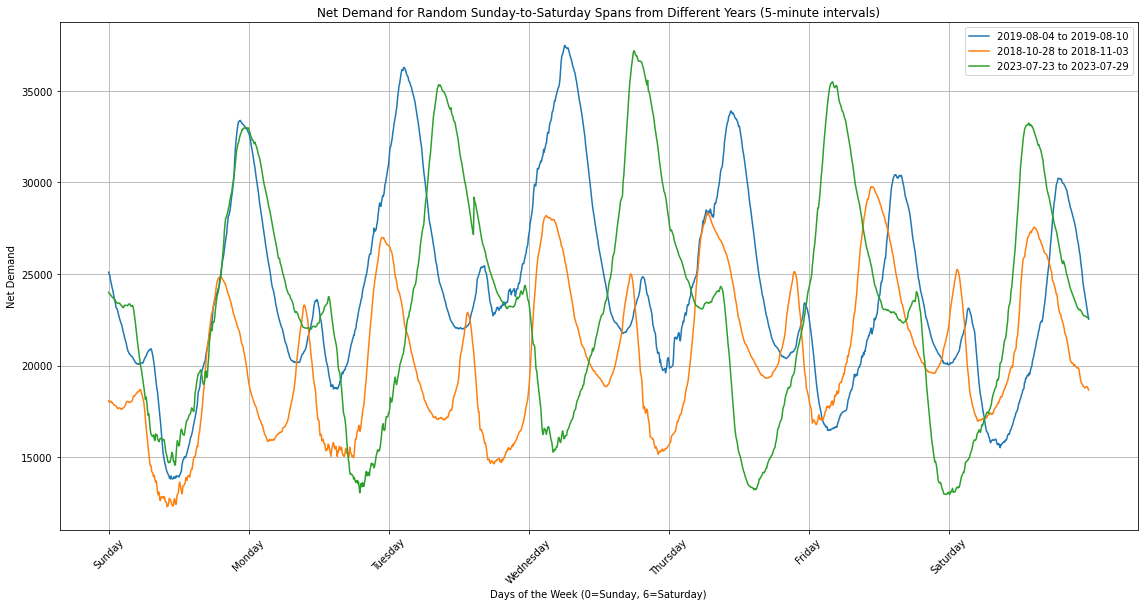

In [120]:
df_final = df_final.sort_index()

# have three years be random
years = np.random.choice(df_final.index.year.unique(), 3, replace=False)

plt.figure(figsize=(16, 8))

for year in years:
    # start on a random sunday
    sunday = np.random.choice(df_final[df_final.index.year == year].index[df_final[df_final.index.year == year].index.weekday == 6])
    sunday_datetime = pd.Timestamp(sunday).to_pydatetime()
    # have the sunday to saturday span
    one_week_data = df_final.loc[sunday:sunday + pd.Timedelta(days=6)]

    plt.plot(np.linspace(0, 7, num=len(one_week_data)), one_week_data['net_demand'], label=f"{sunday_datetime.date()} to {(sunday_datetime + pd.Timedelta(days=6)).date()}")

plt.title('Net Demand for Random Weeks from Different Years')
plt.ylabel('Net Demand')
plt.xlabel('Days of the Week (0=Sunday, 6=Saturday)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(ticks=np.arange(7), labels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], rotation=45)
plt.show()

# 4) Methods to defining "High Demand Days"
I'm defining high demand days as days that are in the top 10% of daily current demand and net demand. This originally was not great because there was a simple cutoff for these days. I added a nuance of having batteries discharging at top 10% daily average levels. This better fits "high demand days" because it indicates that our massive load of renewables is not enough to supply the demand and batteries need to be discharged to continue operations. 

### Method 1: Using all 5 years of data to find high demand days

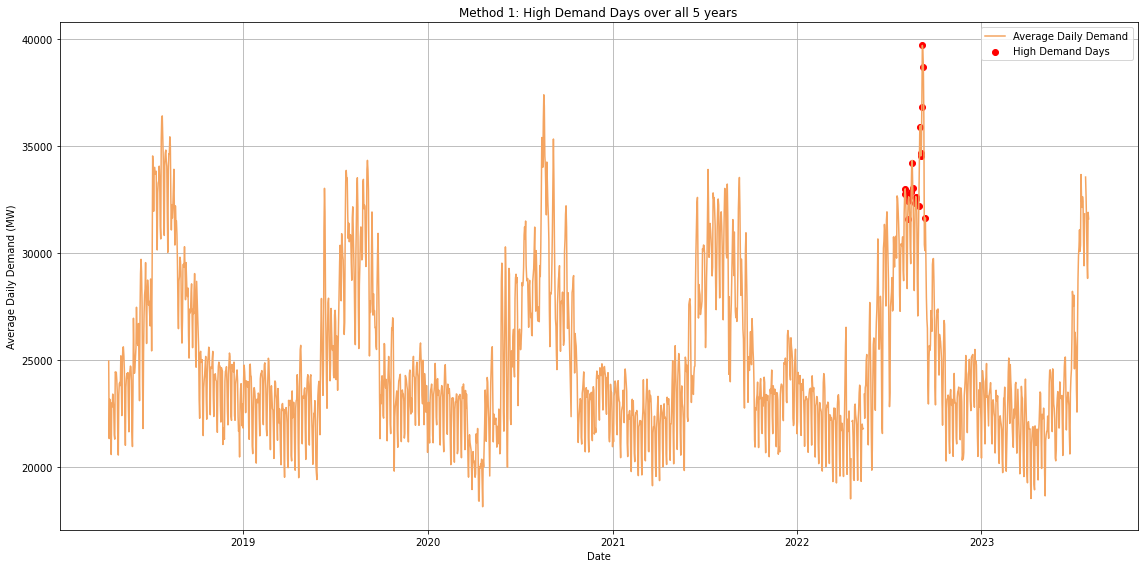

In [37]:
#resample with daily average
daily_avg = df_final.resample('D').mean()

#defining that 90th percentile threshold
threshold_current = daily_avg['current_demand'].quantile(0.9)
threshold_net = daily_avg['net_demand'].quantile(0.9)
threshold_batteries = daily_avg['batteries'].quantile(0.9)

#using threshold to define "is_high_demand"
daily_avg['is_high_demand'] = ((daily_avg['current_demand'] > threshold_current) &
                               (daily_avg['net_demand'] > threshold_net) &
                               (daily_avg['batteries'] > threshold_batteries)).astype(int)

plt.figure(figsize=(16, 8))
plt.plot(daily_avg.index, daily_avg['current_demand'], label='Average Daily Demand', color='sandybrown')

#showing the HDD
high_demand_days = daily_avg[daily_avg['is_high_demand'] == 1]
plt.scatter(high_demand_days.index, high_demand_days['current_demand'], color='red', label='High Demand Days')

plt.title('Method 1: High Demand Days over all 5 years')
plt.xlabel('Date')
plt.ylabel('Average Daily Demand (MW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The practical issue with the above is that it is taking into account all years of data. Given current conditions, demand will undoubtedly increase year over year. Therefore, below I am switching to each year's 90th percentile as a new threshold to see each year's "is_high_demand" days.

### Method 2: Finding high demand days for each year

High demand days for 2018: 2018-07-09, 2018-07-12, 2018-07-20, 2018-07-24
High demand days for 2019: 2019-08-06
High demand days for 2020: 2020-08-27, 2020-09-05
High demand days for 2021: 2021-07-20, 2021-08-04, 2021-08-17
High demand days for 2022: 2022-08-08, 2022-08-15, 2022-08-16, 2022-08-23, 2022-08-26, 2022-09-05
High demand days for 2023: 2023-07-18


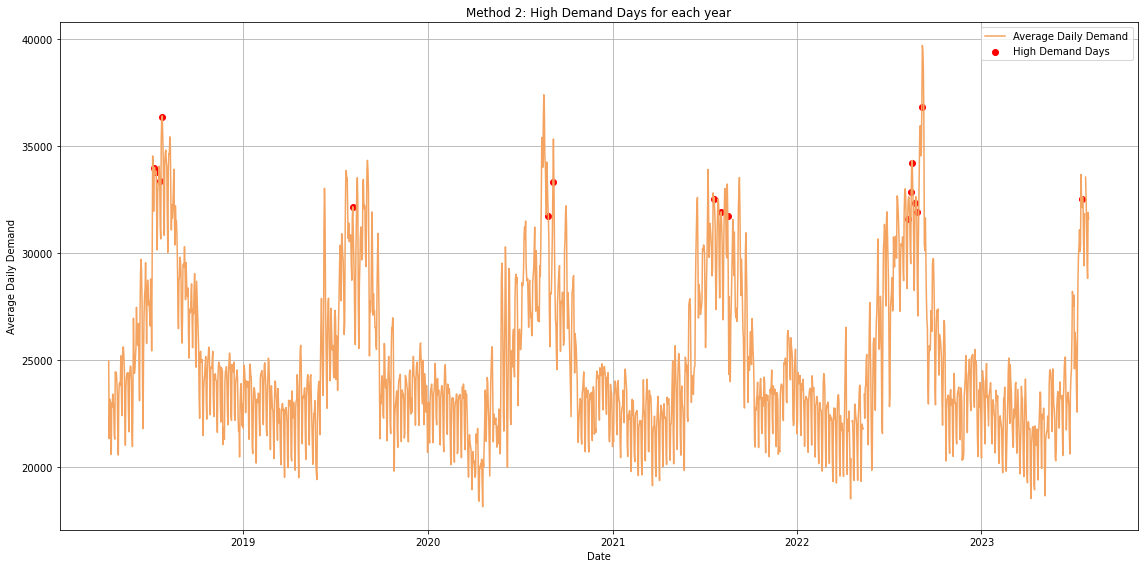

In [65]:
daily_avg = df_final.resample('D').mean()
daily_avg['is_high_demand'] = 0

years = daily_avg.index.year.unique()

for year in years:
    subset = daily_avg[daily_avg.index.year == year].copy()  
    
    threshold_current = subset['current_demand'].quantile(0.9)
    threshold_net = subset['net_demand'].quantile(0.9)
    threshold_batteries = subset['batteries'].quantile(0.9)
    
    mask = (subset['current_demand'] > threshold_current) & \
           (subset['net_demand'] > threshold_net) & \
           (subset['batteries'] > threshold_batteries)
    
    subset.loc[mask, 'is_high_demand'] = 1

    #getting actual dates to show
    high_demand_dates = ", ".join([str(date) for date in subset[mask].index.date])
    print(f"High demand days for {year}: {high_demand_dates}")
    
    daily_avg.update(subset)


plt.figure(figsize=(16, 8))
plt.plot(daily_avg.index, daily_avg['current_demand'], label='Average Daily Demand', color='sandybrown')

#showing the HDD
high_demand_days = daily_avg[daily_avg['is_high_demand'] == 1]
plt.scatter(high_demand_days.index, high_demand_days['current_demand'], color='red', label='High Demand Days')

plt.title('Method 2: High Demand Days for each year')
plt.xlabel('Date')
plt.ylabel('Average Daily Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 5) FFT  of net_demand to identify seasonality
Starting by using daily_avg's net_demand and computing a rolling average (window = 90 days) to obtain less noisy data. Clearly we can see that the demand data looks periodic. I'll performan an FFT to see what periodic behaviors are in the data. We should expect seasonal changes but let's take a look.

In [82]:
# normalize the net_demand data
mean = daily_avg['net_demand'].mean()
std = daily_avg['net_demand'].std()
daily_avg['normalized_net_demand'] = (daily_avg['net_demand']-mean)/std
daily_avg.dropna(inplace=True)

In [91]:
#rolling average
daily_avg['90ma'] = daily_avg['normalized_net_demand'].rolling(90).mean()
daily_avg['normalized_90ma'] = (daily_avg['90ma'] - daily_avg['90ma'].mean())/daily_avg['90ma'].std()
daily_avg.dropna(inplace=True)

#### This last plot illustrates:
1. The daily average of net_demand (MW) given a 90 day moving average 
2. The peaks and magnitude of the amplitude at specific frequencies. Blue: full frequency component decomposition where we plot the amplitude of each frequency mode to identify strong periodicity. Taking the two largest frequency modes by filtering out all frequencies below the amplitude threshold, we get the orange peaks. 
3. The reconstruction of the curve given the top two peaks identified in the FFT (using inverse FFT). The one-year and half-year trends is mostly sufficient to explain the variation trends of the original moving average plot.

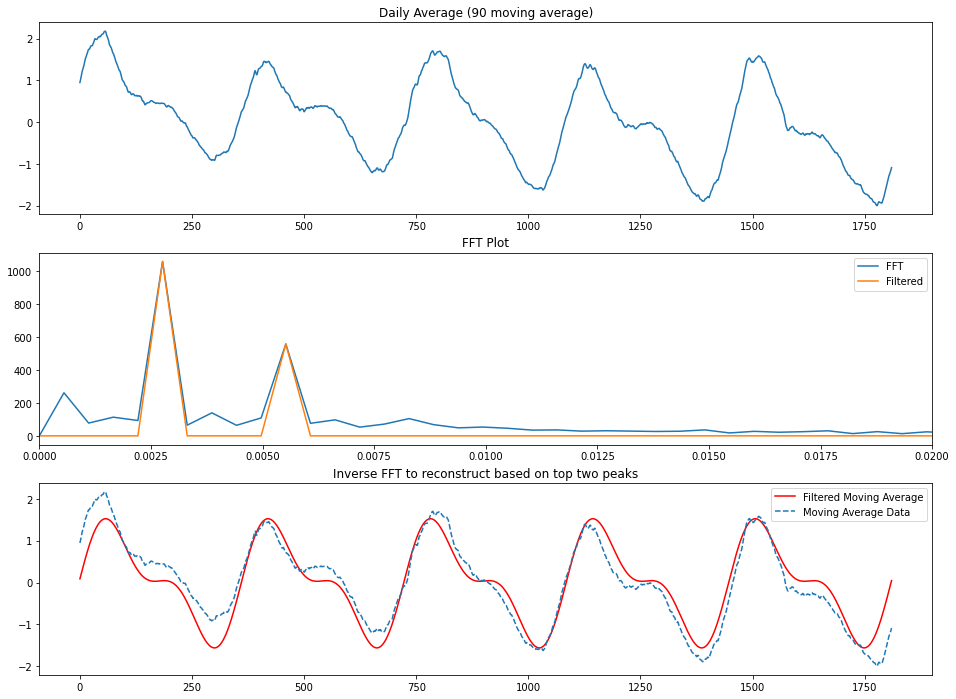

[array([362.2]), array([181.1])]
The highest amplitude corresponds to 362.2 days


In [135]:
fig, ax = plt.subplots(3, figsize=(16,12))

data = daily_avg['normalized_90ma']

fft_values = np.fft.rfft(data.values, n = len(data.values), norm = 'backward')
frequencies = np.fft.rfftfreq(len(data.values))

#filtering to obtain print highest peaks
cut_fft_values = fft_values.copy()
cut_fft_values[(np.abs(fft_values)<270)] = 0

#finding max indices
max_ind = np.where(np.abs(cut_fft_values) == np.max(np.abs(cut_fft_values)))[0]

#current daily average data given 90 day window
ax[0].plot(data.values)
ax[0].set_title('Daily Average (90 moving average)')

#FFT = regular plot of frequency and amplitude
#filtered = taking absolute value of the amplitude
ax[1].plot(frequencies, np.abs(fft_values),label='FFT')
ax[1].plot(frequencies, np.abs(cut_fft_values),label='Filtered')
ax[1].set_xlim([0,0.02])
ax[1].set_title('FFT Plot')
ax[1].legend(loc='best')

#reconstructing the plot using inverse FFT given the two peaks
ax[2].plot( np.fft.irfft(cut_fft_values, n = len(data.values)), label = 'Filtered Moving Average',color='red')
ax[2].plot(data.values, label = 'Moving Average Data',linestyle='--')
ax[2].set_title('Inverse FFT to reconstruct based on top two peaks')
ax[2].legend(loc='upper right')
plt.show()

#printing the values at which the amplitude is the highest and then inversing to find the equivalent number of days
print([1/frequencies[np.where(np.abs(cut_fft_values) == np.abs(i))[0]] for i in np.unique(cut_fft_values) if i != 0j])
print("The highest amplitude corresponds to", float(1/frequencies[max_ind]), "days")